In [ ]:
# here we will take the appointment data and will try to find if there are any interesting patterns, 
# which could further be leaveraged to predict the persons probability to show up for the appointment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [89]:
#importing the data
data =pd.read_csv("../Hackethon/AppointMentNoShow/data.csv",na_values=[" ",np.nan,"NA"])
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [90]:
#Data has many categorical fields ,timestamps, removing patient id and appointmrnt id
#patient id can be a deciding factor as few patients may have tendency to miss their appointments but we will do it later
print (len(data.PatientId.unique()))
print (len(data.PatientId))

61744
110527


In [91]:
# we see that there are only 62299 unique patients,while we have data for 110527 patients.
#it can be anyone of two things
# 1. some patient came again for a fresh appointment
# 2. patient who missed the previous appointment booked it again
# we will not drop the patient id will convert it into a category(it will be an oerhead but worth checking)
data = data.drop("AppointmentID",1)

In [92]:
data.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [93]:
#Checking for unique categories
print data.Scholarship.unique()
print data.Hipertension.unique()
print data.Diabetes.unique()
print data.Alcoholism.unique()
print data.Handcap.unique()
print data.SMS_received.unique()
print data.No_show.unique()

[0 1]
[1 0]
[0 1]
[0 1]
[0 1 2 3 4]
[0 1]
['No' 'Yes']


In [94]:
#All the categorical variables seems to have valid categories .
#only handicap has 5 categories.
# excluding handcap ,these variables will be converted into levels. for handcap, we will use dummy variables
# (we could use dummy variables for all but not taking since there are only two levels and one will be considered in intercept)

In [95]:
#lets convert the time fiels to time format
data.ScheduledDay = pd.to_datetime(data.ScheduledDay)
data.AppointmentDay = pd.to_datetime(data.AppointmentDay)

In [96]:
print data.ScheduledDay.head()
print data.AppointmentDay.head()

0   2016-04-29 18:38:08
1   2016-04-29 16:08:27
2   2016-04-29 16:19:04
3   2016-04-29 17:29:31
4   2016-04-29 16:07:23
Name: ScheduledDay, dtype: datetime64[ns]
0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2016-04-29
Name: AppointmentDay, dtype: datetime64[ns]


In [97]:
# getting day difference bw day of appointment and day of schduling
#adding additional one as for the appointment on same day it gives -1
from datetime import datetime
data["daysToappointment"]= (data.AppointmentDay-data.ScheduledDay).dt.days +1

In [98]:
#Getting hour of booking
def houroftheday(timestamp):
#     converting to string so that the hours can be picked using the character index
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute =int(timestamp[14:16])
    seconds = int(timestamp[17:])
    Hour = round(hour +(minute/60) +(seconds/3600))
    return Hour

In [99]:
data["hourOfBooking"] = data.ScheduledDay.apply(houroftheday)

In [100]:
data["hourOfBooking"].head()

0    18.0
1    16.0
2    16.0
3    17.0
4    16.0
Name: hourOfBooking, dtype: float64

In [101]:
#checking for null values
data.isnull().sum()
#no missing values are here ( something good...right)

PatientId            0
Gender               0
ScheduledDay         0
AppointmentDay       0
Age                  0
Neighbourhood        0
Scholarship          0
Hipertension         0
Diabetes             0
Alcoholism           0
Handcap              0
SMS_received         0
No_show              0
daysToappointment    0
hourOfBooking        0
dtype: int64

In [102]:
#now look at the variables
#stating with age
data.Age.describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

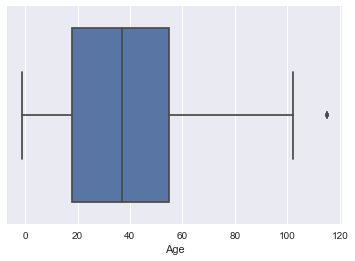

In [103]:
#age has an interesting distribution
#it has negative values and very high positive values
# we may all together remove records with negative and very high ages
# or we can keep them , convert these to categories and add a bolean field symbolising the falseness of the record
#let's see the boxplot first

sns.boxplot(data.Age)

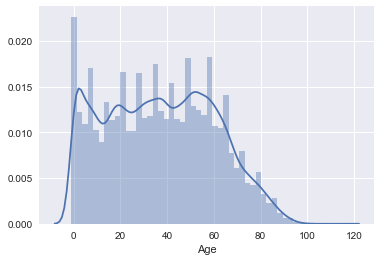

In [104]:
#we will ignore anything above 100 as high age and below 0 as low age
sns.distplot(data.Age)

In [105]:
#there are very few people above 100 and  below 0
data["falseAge"] = 1
data.loc[(data.Age>=0 ) & (data.Age<=100),"falseAge"]=0

In [106]:
data.falseAge.unique()

array([0, 1], dtype=int64)

In [115]:
data["AgeCategory"] = pd.cut(data["Age"],bins =[-2,18,37,55,116],labels=["child","young","midage","elder"])

In [116]:
data["AgeCategory"].unique()

[elder, child, young, midage]
Categories (4, object): [child < young < midage < elder]

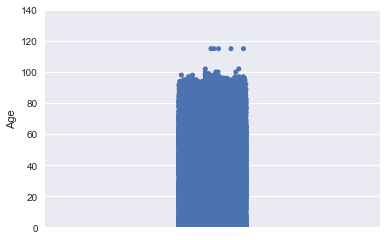

In [120]:
sns.stripplot(data=data,y="Age",jitter=True)
sns.plt.ylim(0,140)
sns.plt.show()

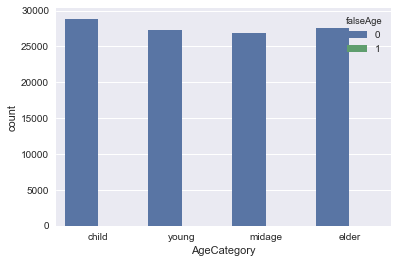

In [123]:
#looking at AgeCategory variable(this way we preserved the outlier values)
sns.countplot(data=data,x="AgeCategory",hue="falseAge")

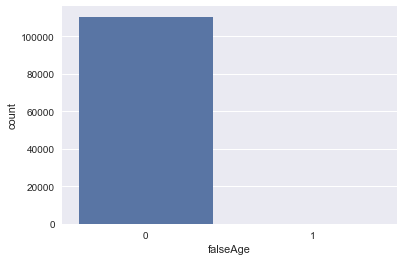

In [122]:
sns.countplot(data=data,x="falseAge")

In [124]:
len(data[(data.falseAge==1)])

8

In [125]:
data.columns

Index([u'PatientId', u'Gender', u'ScheduledDay', u'AppointmentDay', u'Age',
       u'Neighbourhood', u'Scholarship', u'Hipertension', u'Diabetes',
       u'Alcoholism', u'Handcap', u'SMS_received', u'No_show',
       u'daysToappointment', u'hourOfBooking', u'falseAge', u'AgeCategory'],
      dtype='object')

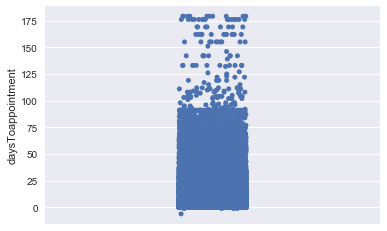

In [127]:
#exploring daysToappointment
sns.stripplot(data=data,y="daysToappointment",jitter=True)


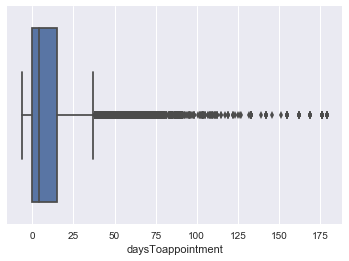

In [128]:
sns.boxplot(data.daysToappointment)

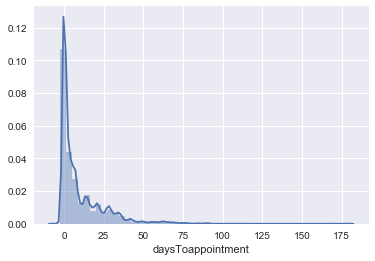

In [129]:
sns.distplot(data.daysToappointment)

In [130]:
data.daysToappointment.describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: daysToappointment, dtype: float64

In [131]:
#We see a few values are negative, removing them
data = data[data.daysToappointment>=0]

In [132]:
data.daysToappointment.describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: daysToappointment, dtype: float64

In [134]:
#We see the distribution of days to appointment is very skewed, and perhaps we need to remove outliers,
# let's follow the same approach as above , create the category and an outlier column

data["distantAppointment"] = 1
data.loc[(data.daysToappointment<=50),"distantAppointment"]=0

In [141]:
data["daystoAppointmentcat"] =pd.cut(data.daysToappointment,bins=[-1,2,4,15,50,180],labels=["urgent","very near","moderate","distant","far away"])

In [142]:
data.daystoAppointmentcat.head()

0    urgent
1    urgent
2    urgent
3    urgent
4    urgent
Name: daystoAppointmentcat, dtype: category
Categories (5, object): [urgent < very near < moderate < distant < far away]

In [145]:
Y = data.No_show
data =data.drop("No_show",1)

In [147]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder
from numpy import column_stack


In [150]:
data =data.drop(["PatientId","Age","Neighbourhood","daysToappointment","AppointmentDay","ScheduledDay"],1)

In [152]:
data.columns

Index([u'Gender', u'ScheduledDay', u'AppointmentDay', u'Scholarship',
       u'Hipertension', u'Diabetes', u'Alcoholism', u'Handcap',
       u'SMS_received', u'hourOfBooking', u'falseAge', u'AgeCategory',
       u'distantAppointment', u'daystoAppointmentcat'],
      dtype='object')

In [157]:
data.dtypes

Gender                    object
Scholarship                int64
Hipertension               int64
Diabetes                   int64
Alcoholism                 int64
Handcap                    int64
SMS_received               int64
hourOfBooking            float64
falseAge                   int64
AgeCategory             category
distantAppointment         int64
daystoAppointmentcat    category
dtype: object

In [159]:
data =data.values

In [164]:
data.shape

(110522L, 12L)

In [162]:
data =data.astype(str)
Columns =[]
labelEncoder =LabelEncoder()
for i in range(data.shape[1]):
    feature = labelEncoder.fit_transform(data[:,i])
    feature = feature.reshape(data.shape[0],1)
    oneHotEncoder = OneHotEncoder(sparse=False)
    Feature_encoded = oneHotEncoder.fit_transform(feature)
    Columns.append(Feature_encoded)
X_Encoded = column_stack(Columns)

In [163]:
X_Encoded

array([[ 1.,  0.,  1., ...,  0.,  1.,  0.],
       [ 0.,  1.,  1., ...,  0.,  1.,  0.],
       [ 1.,  0.,  1., ...,  0.,  1.,  0.],
       ..., 
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.]])

In [166]:
TrainS = X_Encoded[:70000,:]
TestS  =X_Encoded[70000:,:]

In [167]:
Y_New = Y[:70000]

In [168]:
Y_Trans = labelEncoder.fit_transform(Y_New)
XTrain,XTest,YTrain,YTest = train_test_split(TrainS,Y_Trans,test_size = 0.2,random_state = 7)

In [179]:
from sklearn.naive_bayes import MultinomialNB

clf =  MultinomialNB().fit(XTrain, YTrain)
print('Accuracy:', round(accuracy_score(YTest, 
                                        clf.predict(XTest)), 2) * 100, '%')

('Accuracy:', 78.0, '%')


In [180]:
confusion_matrix(YTest,clf.predict(XTest))

array([[10735,   327],
       [ 2738,   200]])

In [ ]:
Y_Trans = labelEncoder.fit_transform(Y[70000:])

In [171]:
y_pred =clf.predict(TestS)

In [177]:
accuracy_score(Y_Trans,y_pred)

0.80294654755441486

In [178]:
confusion_matrix(Y_Trans,y_pred)

array([[31917,  1072],
       [ 6913,   620]])